In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn import metrics
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
df = pd.read_csv("crash.csv", encoding='windows-1252')

In [3]:
df.head()

,Master Record Number,Year,Month,Day,Weekend?,Hour,Collision Type,Injury Type,Primary Factor,Reported_Location,Latitude,Longitude
0,902363382,2015,1,5,Weekday,0.0,2-Car,No injury/unknown,OTHER (DRIVER) - EXPLAIN IN NARRATIVE,1ST & FESS,39.159207,-86.525874
1,902364268,2015,1,6,Weekday,1500.0,2-Car,No injury/unknown,FOLLOWING TOO CLOSELY,2ND & COLLEGE,39.161440,-86.534848
2,902364412,2015,1,6,Weekend,2300.0,2-Car,Non-incapacitating,DISREGARD SIGNAL/REG SIGN,BASSWOOD & BLOOMFIELD,39.149780,-86.568890
3,902364551,2015,1,7,Weekend,900.0,2-Car,Non-incapacitating,FAILURE TO YIELD RIGHT OF WAY,GATES & JACOBS,39.165655,-86.575956
4,902364615,2015,1,7,Weekend,1100.0,2-Car,No injury/unknown,FAILURE TO YIELD RIGHT OF WAY,W 3RD,39.164848,-86.579625


In [4]:
features = ["Master Record Number","Year", "Month", "Day", "Weekend?", "Hour", "Collision Type"]

In [5]:
df = df.dropna(subset=features)

In [6]:
df['Weekend?'] = df['Weekend?'].replace(['Weekend', 'Weekday'], [1, 0])
df['Weekend?'] = df['Weekend?'].astype(int)
df['Collision Type'] = df['Collision Type'].replace(['1-Car', '2-Car', '3+ Cars', 'Pedestrian', 'Cyclist', 'Moped/Motorcycle', 'Bus'], [1, 2, 3, 4, 5, 6, 7])
df

,Master Record Number,Year,Month,Day,Weekend?,Hour,Collision Type,Injury Type,Primary Factor,Reported_Location,Latitude,Longitude
0,902363382,2015,1,5,0,0.0,2,No injury/unknown,OTHER (DRIVER) - EXPLAIN IN NARRATIVE,1ST & FESS,39.159207,-86.525874
1,902364268,2015,1,6,0,1500.0,2,No injury/unknown,FOLLOWING TOO CLOSELY,2ND & COLLEGE,39.161440,-86.534848
2,902364412,2015,1,6,1,2300.0,2,Non-incapacitating,DISREGARD SIGNAL/REG SIGN,BASSWOOD & BLOOMFIELD,39.149780,-86.568890
3,902364551,2015,1,7,1,900.0,2,Non-incapacitating,FAILURE TO YIELD RIGHT OF WAY,GATES & JACOBS,39.165655,-86.575956
4,902364615,2015,1,7,1,1100.0,2,No injury/unknown,FAILURE TO YIELD RIGHT OF WAY,W 3RD,39.164848,-86.579625
...,...,...,...,...,...,...,...,...,...,...,...,...
53938,900084526,2003,10,6,0,1700.0,2,No injury/unknown,IMPROPER LANE USAGE,DUNN & WHITE LOT WEST,0.000000,0.000000
53939,900089213,2003,11,3,0,800.0,1,No injury/unknown,UNSAFE SPEED,RED OAK & SR446,0.000000,0.000000
53940,900095322,2003,12,5,0,1200.0,2,No injury/unknown,BRAKE FAILURE OR DEFECTIVE,2ND ST & WALNUT,0.000000,0.000000
53941,900099922,2003,12,1,1,700.0,2,No injury/unknown,UNSAFE BACKING,NINETH & NORTH,0.000000,0.000000


In [7]:
year = df.loc[:, 'Year']
month = df.loc[:, 'Month']
day = df.loc[:, 'Day']

In [8]:
years = []
months = []
days = []
for row in year:
    years.append(row)
    
for row in month:
    months.append(row)
    
for row in day:
    days.append(row)

In [9]:
data = df[features].copy()

In [10]:
data

,Master Record Number,Year,Month,Day,Weekend?,Hour,Collision Type
0,902363382,2015,1,5,0,0.0,2
1,902364268,2015,1,6,0,1500.0,2
2,902364412,2015,1,6,1,2300.0,2
3,902364551,2015,1,7,1,900.0,2
4,902364615,2015,1,7,1,1100.0,2
...,...,...,...,...,...,...,...
53938,900084526,2003,10,6,0,1700.0,2
53939,900089213,2003,11,3,0,800.0,1
53940,900095322,2003,12,5,0,1200.0,2
53941,900099922,2003,12,1,1,700.0,2


In [11]:
data = ((data-data.min())/(data.max()-data.min()))*9+1

In [12]:
data.describe()

,Master Record Number,Year,Month,Day,Weekend?,Hour,Collision Type
count,53712.000000,53712.000000,53712.000000,53712.000000,53712.000000,53712.000000,53712.000000
mean,7.756070,5.491943,5.635617,5.795213,3.216153,6.271980,2.606792
std,3.880215,2.837556,2.875100,2.863372,3.877412,2.080336,1.545620
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,9.973881,3.250000,3.454545,4.000000,1.000000,4.913043,2.500000
50%,9.984946,5.500000,5.909091,5.500000,1.000000,6.478261,2.500000
75%,9.992695,7.750000,8.363636,8.500000,1.000000,7.652174,2.500000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [13]:
data.head()

,Master Record Number,Year,Month,Day,Weekend?,Hour,Collision Type
0,9.997248,10.0,1.0,7.0,1.0,1.000000,2.5
1,9.997257,10.0,1.0,8.5,1.0,6.869565,2.5
2,9.997258,10.0,1.0,8.5,10.0,10.000000,2.5
3,9.997259,10.0,1.0,10.0,10.0,4.521739,2.5
4,9.997260,10.0,1.0,10.0,10.0,5.304348,2.5


KMeans

In [14]:
def random_centroids(data, k):
    centroids=[]
    for i in range(k):
        centroid =data.apply(lambda x: float(x.sample()))
        centroids.append(centroid)
    return pd.concat(centroids, axis=1)

In [15]:
centroids = random_centroids(data,2)

In [16]:
print(centroids)

                              0         1
Master Record Number   9.982476  1.001967
Year                  10.000000  6.250000
Month                  1.000000  2.636364
Day                    4.000000  8.500000
Weekend?               1.000000  1.000000
Hour                   7.260870  8.043478
Collision Type         8.500000  2.500000


In [17]:
def get_labels(data, centroids):
    distances = centroids.apply(lambda x: np.sqrt(((data-x) ** 2).sum(axis=1)))
    return distances.idxmin(axis=1)

In [18]:
labels = get_labels(data,centroids)

In [19]:
labels.value_counts()

0    31134
1    22578
dtype: int64

In [20]:
def new_cenroids(data, labels, k):
    data.groupby(labels).apply(lambda x: np.exp(np.log(x).mean())).T

In [21]:
def plot_clusters(data, labels, centroids, iteration):
    pca = PCA(n_components = 2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids.T)
    clear_output(wait=True)
    plt.title(f'Iteraion{iteration}')
    plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels)
    plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:1])
    plt.show()

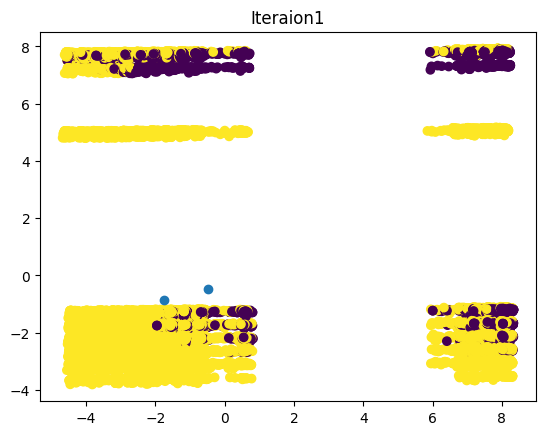

In [22]:
max_iterations = 100
k = 2

centroids = random_centroids(data, k)
old_centroids = pd.DataFrame()
iteration = 1

while iteration < max_iterations and not centroids.equals(old_centroids):
    old_centroids = centroids
    labels = get_labels(data, centroids)
    plot_clusters(data, labels, centroids, iteration)
    iteration += 1

DBScan

In [23]:
x = data.iloc[:, [0, 1]].values
x

array([[ 9.99724771, 10.        ],
       [ 9.99725654, 10.        ],
       [ 9.99725798, 10.        ],
       ...,
       [ 9.97463306,  1.        ],
       [ 9.97467892,  1.        ],
       [ 9.97477234,  1.        ]])

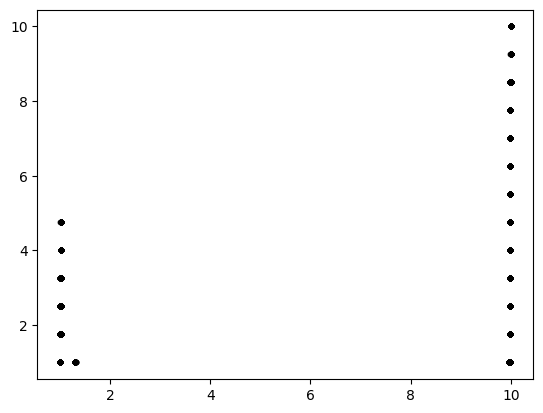

In [24]:
plt.scatter(x[:, 0], x[:, 1], s=10, c="black")

In [25]:
db = DBSCAN(eps = 0.1, min_samples = 10).fit(x)
core_samples_mask = np.zeros_like(db.labels_, dtype = bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [26]:
labels

array([ 0,  0,  0, ..., 18, 18, 18], dtype=int64)

In [27]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

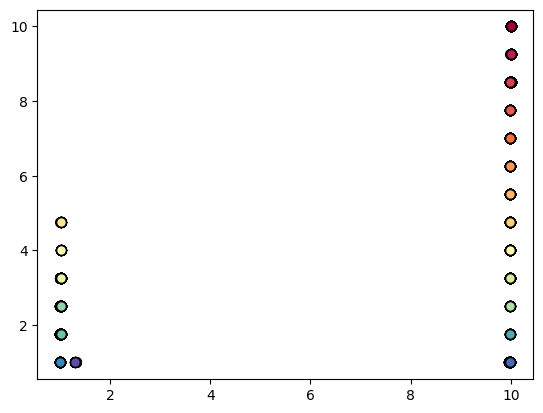

In [28]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = x[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=7,
    )

    xy = x[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=3,
    )

plt.show()